In [1]:
import zipfile, os, cv2
import numpy as np
import tensorflow as tf
tf.executing_eagerly()
from tensorflow import keras
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras import backend as K
K.set_image_data_format('channels_last')

In [2]:
size = 192
depth = 32
ALL_data_paths = [
    os.path.join(os.getcwd(), "is0001-is0154_mask_and_image/", x)
    for x in sorted(os.listdir("is0001-is0154_mask_and_image/"))
]
print("MRI scans dataset: " + str(len(ALL_data_paths)//2) + ' ALL')
mask = []
image = []
for i in ALL_data_paths:
    if 's.nii.gz' in i:
        mask.append(i)
    else:
        image.append(i)
print(len(mask), len(image))

MRI scans dataset: 130 ALL
130 130


In [3]:
import nibabel as nib
from skimage import morphology
from scipy import ndimage
from PIL import Image

def normalize(volume, norm_type):
    """Normalize the volume"""
#     min = np.min(volume)
#     max = np.max(volume)
#     volume[volume < min] = min
#     volume[volume > max] = max
#     volume = (volume - min) / (max - min)
    if norm_type == 'zero_mean':
        img_o = np.float32(volume.copy())
        m = np.mean(img_o)
        s = np.std(img_o)
        volume = np.divide((img_o - m), s)
    elif norm_type == 'div_by_max':
        volume = np.divide(volume, np.percentile(volume,98))
    volume = volume.astype("float32")
    return volume

def remove_noise_from_image(file_path):
    image = nib.load(file_path)
    if len(image.shape) == 4:
        image = image.get_fdata()
        width,height,queue,_ = image.shape
        image = image[:,:,:,1]
        image = np.reshape(image,(width,height,queue))
    else:
        image = image.get_fdata()
        pass
    shape = image.shape
    for i in range(shape[2]):
        image_2d = image[:, :, i]
#         mask = image_2d <=20
        mask = image_2d<=10
        selem = morphology.disk(2)

        segmentation = morphology.dilation(mask, selem)
        labels, label_nb = ndimage.label(segmentation)

        mask = labels ==0
        mask = morphology.dilation(mask, selem)
        mask = ndimage.morphology.binary_fill_holes(mask)
        mask = morphology.dilation(mask, selem)

        image[:, :, i] = mask * image_2d
    image = normalize(image,"div_by_max")
    return image

def resize_volume(img,size,depth):
    """Resize across z-axis"""
    # Set the desired depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
        # Rotate img shape = (height, wight, depth)
    for i in range(img.shape[2]):
        img[:,:,i] = np.fliplr(np.flipud(img[:,:,i]))
#     img = ndimage.rotate(img, 180, reshape=False, mode="nearest")
    img = ndimage.zoom(img, (size/current_height, size/current_width, 1), order=0)
    return img

In [4]:
def process_scan(path):
#     # Resize width, height and depth
    volume = remove_noise_from_image(path)
    volume = resize_volume(volume,size,depth)
#   add only black background mri image
    if volume.shape[2]!=depth:
        add_black_num = depth - volume.shape[2]
        volume = np.transpose(volume)
        for i in range(add_black_num):
            add_black_ = np.expand_dims(np.zeros((volume.shape[2],volume.shape[2])),axis=0)
            volume = np.concatenate((volume, add_black_), axis = 0)
        volume = np.transpose(volume)
    volume = np.transpose(volume)
    print(path)
    print(f"rebuild shape: {volume.shape}")
    return volume
def mask_scan(path):
#     print(path)
    image = nib.load(path)
    
    if len(image.shape) == 4:
        image = image.get_fdata()
        width,height,queue,_ = image.shape
        image = image[:,:,:,1]
        image = np.reshape(image,(width,height,queue))
    else:
        image = image.get_fdata()
        pass
    image = resize_volume(image,size,depth)
    shape = image.shape
#   add only black background mri image
    if image.shape[2]!=depth:
        add_black_num = depth - image.shape[2]
        image = np.transpose(image)
        for i in range(add_black_num):
            add_black_ = np.expand_dims(np.zeros((image.shape[2],image.shape[2])),axis=0)
            image = np.concatenate((image, add_black_), axis = 0)
        image = np.transpose(image)
    image = np.transpose(image)
    print(path)
    print(f"rebuild shape: {image.shape}")
    return image

In [5]:
import pandas as pd
MRI_csv = pd.read_csv('NIHSS.csv')
save_list = ["ID","A/P"]
MRI_csv = np.array(MRI_csv[save_list])
mask = np.array(mask)
image = np.array(image)
print(MRI_csv.shape)
print(image[0])
print(mask[0][-14:])

(154, 2)
/ssd1/cnn/Classification/3d_mask_classification/is0001-is0154_mask_and_image/is0001o.nii.gz
is0001s.nii.gz


In [6]:
MRI_image_A=[]
MRI_mask_A=[]
MRI_image_P=[]
MRI_mask_P=[]
for i in (MRI_csv):
    for j in image:
        if i[0] in j[-14:]:
            if i[1]=='A':
                MRI_image_A.append(j)
            elif i[1]=='P':
                MRI_image_P.append(j)
    for j in mask:
        if i[0] in j[-14:]:
            if i[1]=='A':
                MRI_mask_A.append(j)
            elif i[1]=='P':
                MRI_mask_P.append(j)
       

In [7]:
# image_arr_A = np.array([process_scan(path) for path in MRI_image_A])
# print("Done")
# mask_arr_A = np.array([mask_scan(path) for path in MRI_mask_A])
# print("Done")
# image_arr_P = np.array([process_scan(path) for path in MRI_image_P])
# print("Done")
# mask_arr_P = np.array([mask_scan(path) for path in MRI_mask_P])
# print("Done")

In [8]:
# print(mask_arr_P.shape)

In [9]:
# np.save('np_multi/image_arr_A_154', image_arr_A)
# np.save('np_multi/mask_arr_A_154', mask_arr_A)
# np.save('np_multi/image_arr_P_154', image_arr_P)
# np.save('np_multi/mask_arr_P_154', mask_arr_P)
image_arr_A = np.load('np_multi/image_arr_A_154.npy').astype(np.float32)
mask_arr_A = np.load('np_multi/mask_arr_A_154.npy').astype(np.float32)
image_arr_P = np.load('np_multi/image_arr_P_154.npy').astype(np.float32)
mask_arr_P = np.load('np_multi/mask_arr_P_154.npy').astype(np.float32)
print(image_arr_A.shape, mask_arr_A.shape, image_arr_P.shape, mask_arr_P.shape)


(81, 32, 192, 192) (81, 32, 192, 192) (49, 32, 192, 192) (49, 32, 192, 192)


pixel max = 1.0 pixel min = 0.0


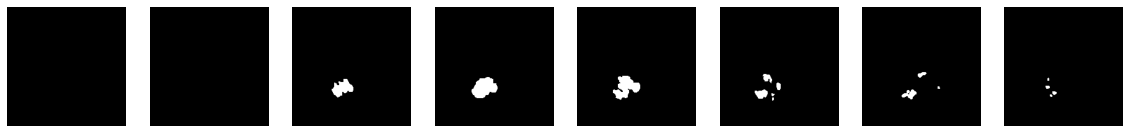

In [10]:
plt.figure(figsize=(20,20))
mask_arr_ = mask_arr_P[20]
print(f"pixel max = {np.max(mask_arr_)} pixel min = {np.min(mask_arr_)}")
for i in range(mask_arr_.shape[0]-24):
    plt.subplot(1,mask_arr_.shape[0]-24,i+1)
    plt.axis('off')
    plt.imshow(mask_arr_[i],cmap='gray')

In [11]:
from keras.utils.np_utils import to_categorical
image_arr_A = np.transpose(image_arr_A,(0,2,3,1))
mask_arr_A = np.transpose(mask_arr_A,(0,2,3,1))
image_arr_P = np.transpose(image_arr_P,(0,2,3,1))
mask_arr_P = np.transpose(mask_arr_P,(0,2,3,1))

image_arr_A = np.expand_dims(image_arr_A, axis=-1)
mask_arr_A = np.expand_dims(mask_arr_A, axis=-1)
image_arr_P = np.expand_dims(image_arr_P, axis=-1)
mask_arr_P = np.expand_dims(mask_arr_P, axis=-1)
print(image_arr_A.shape, mask_arr_A.shape, image_arr_P.shape, mask_arr_P.shape)

(81, 192, 192, 32, 1) (81, 192, 192, 32, 1) (49, 192, 192, 32, 1) (49, 192, 192, 32, 1)


In [12]:
from keras.utils.np_utils import to_categorical
# seed = np.random.randint(200)
seed = 123
# random shuffle dataset
# seed: cv1=1 cv2=123 cv3=456 cv4=789 cv5=987
def random_data_shuffle(data_arr):
    np.random.seed(seed)
    np.random.shuffle(data_arr) #image
    return data_arr

image_arr_A = random_data_shuffle(image_arr_A)
mask_arr_A = random_data_shuffle(mask_arr_A)
image_arr_P = random_data_shuffle(image_arr_P)
mask_arr_P = random_data_shuffle(mask_arr_P)
MRI_mask_A = random_data_shuffle(MRI_mask_A)
MRI_mask_P = random_data_shuffle(MRI_mask_P)

In [13]:
mask_arr_P=mask_arr_P*2

In [14]:
mask_arr_A = to_categorical(mask_arr_A, 3 ,dtype='uint8')
mask_arr_P = to_categorical(mask_arr_P, 3 ,dtype='uint8')

In [15]:
A_size = int(image_arr_A.shape[0]*0.8)
P_size = int(image_arr_P.shape[0]*0.8)
print(image_arr_A.shape, mask_arr_A.shape, image_arr_P.shape, mask_arr_P.shape)
print(A_size, P_size)

(81, 192, 192, 32, 1) (81, 192, 192, 32, 3) (49, 192, 192, 32, 1) (49, 192, 192, 32, 3)
64 39


In [16]:
x_train = np.concatenate((image_arr_A[:A_size], image_arr_P[:P_size]), axis=0)
y_train = np.concatenate((mask_arr_A[:A_size], mask_arr_P[:P_size]), axis=0)
x_val = np.concatenate((image_arr_A[A_size:], image_arr_P[P_size:]), axis=0)
y_val = np.concatenate((mask_arr_A[A_size:], mask_arr_P[P_size:]), axis=0)

In [17]:
train_path = np.concatenate((MRI_mask_A[:A_size], MRI_mask_P[:P_size]), axis=0)
valid_path = np.concatenate((MRI_mask_A[A_size:], MRI_mask_P[P_size:]), axis=0)

In [18]:
imgs_train = x_train  # scale masks to [0, 1]
imgs_valid = x_val# scale masks to [0, 1]
imgs_mask_train = y_train # scale masks to [0, 1]
imgs_mask_valid = y_val  # scale masks to [0, 1]
print(imgs_train.shape)
print(imgs_mask_train.shape)
print(imgs_valid.shape)
print(imgs_mask_valid.shape)

(103, 192, 192, 32, 1)
(103, 192, 192, 32, 3)
(27, 192, 192, 32, 1)
(27, 192, 192, 32, 3)


In [19]:
from augmented import generator

image_aug = generator.customImageDataGenerator(
            rotation_range = 20,
#             horizontal_flip=True
            
#             brightness_range=[0.5,1.0]
            )

mask_aug = generator.customImageDataGenerator(
#             featurewise_center=True,
#             featurewise_std_normalization=True,
            rotation_range = 20,
#             horizontal_flip=True
#             brightness_range=[0.5,1.5]
            )

image_aug_valid = generator.customImageDataGenerator(
            )

mask_aug_valid = generator.customImageDataGenerator(
            )

In [20]:
bs = 2

X_train_datagen = image_aug.flow(imgs_train, batch_size=bs, seed=seed)
Y_train_datagen = mask_aug.flow(imgs_mask_train, batch_size=bs, seed=seed)
train_generator = zip(X_train_datagen, Y_train_datagen)

X_valid_datagen = image_aug_valid.flow(imgs_valid, batch_size=bs, seed=seed)
Y_valid_datagen = mask_aug_valid.flow(imgs_mask_valid, batch_size=bs, seed=seed)
valid_generator = zip(X_valid_datagen, Y_valid_datagen)

In [21]:
def dice_coef(y_true, y_pred):
    smooth = 0
    intersection = K.sum(y_true * y_pred, axis=(1,2,3))
    union = K.sum(y_true, axis=(1,2,3)) + K.sum(y_pred, axis=(1,2,3))
    sample_dices=(2. * intersection + smooth) / (union + smooth) #一维数组 为各个类别的dice
    dices=K.mean(sample_dices,axis=0)
    dice_coef=K.mean(dices)
    return dice_coef

def dice_coef_loss(y_true,y_pred):
    dice_loss = 1-1-dice_coef(y_true,y_pred)
    return dice_loss

def tversky_coef(y_true, y_pred):
    alpha = 0.2
    beta = 0.8
    p0 = y_pred  # proba that voxels are class i
    p1 = 1 - y_pred  # proba that voxels are not class i
    g0 = y_true
    g1 = 1 - y_true

    # 求得每个sample的每个类的dice
    num = K.sum(p0 * g0, axis=( 1, 2, 3))
    den = num + alpha * K.sum(p0 * g1,axis= ( 1, 2, 3)) + beta * K.sum(p1 * g0, axis=( 1, 2, 3))
    T = num / den  #[batch_size,class_num]

    # 求得每个类的dice
    dices=K.mean(T,axis=0) #[class_num]

    return K.mean(dices)


def tversky_loss(y_true,y_pred):
    return 1-tversky_coef(y_true, y_pred)



In [22]:
from model_library.model_3d_denseunet_multi import threed_unet
from keras.optimizers import Adam
from keras import backend as K
# fitting shape [[slice, w, h, c], class]
model = threed_unet()
learning_rate = 1e-5
epoch = 150
learning_decay_rate = learning_rate/epoch
model.compile(optimizer=Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, 
                             decay=learning_decay_rate, amsgrad=False), 
           loss=tversky_loss, metrics=['accuracy',tversky_coef])

# model.compile(optimizer=Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, 
#                              decay=learning_decay_rate, amsgrad=False), 
#            loss=general_dice_loss, metrics=['accuracy',general_dice])

# model.summary()

In [23]:
from keras.callbacks import ModelCheckpoint, TensorBoard
weight_dir = 'checkpoint'
checkpoint_name = 'mcUnet_mri-best_cv2_aug_tversky_dense_3d_154_t1'
# model.load_weights(os.path.join(weight_dir,checkpoint_name+'.hdf5'))
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
# checkpoint_name = 'Unet_mri-epoch:{epoch:02d}-loss:{loss:.2f}-Dice:{dice_coef:.4f}.hdf5'

model_checkpoint = ModelCheckpoint(os.path.join(weight_dir+'/metric_try4',f"{checkpoint_name}.hdf5"), 
                                   monitor='val_loss', mode="auto", verbose=0, save_best_only=True)
logdir = os.path.join("checkpoint/tensorboard3/", checkpoint_name)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1,
                                         embeddings_freq=0,embeddings_layer_names=None,)


In [ ]:
print('-'*30,'\nFitting model...\n','-'*30)
# history = model.fit(imgs_train, imgs_mask_train, batch_size=1, epochs=epoch, verbose=1, 
#                     shuffle=True, validation_data=(imgs_valid,imgs_mask_valid), 
#                     callbacks=[model_checkpoint,tensorboard_callback])
history = model.fit(train_generator, epochs=epoch, 
                    verbose=0,
                    steps_per_epoch= (len(imgs_train))//bs,
                    shuffle=True, validation_data=valid_generator,
                    validation_steps= len(imgs_valid)//bs,          
                    callbacks=[model_checkpoint,tensorboard_callback])

print("Training Done")
# history = model.fit(train_dataset, epochs=epoch, verbose=2, 
#                     shuffle=True, validation_data=validation_dataset, 
#                     callbacks=[model_checkpoint,tensorboard_callback])


------------------------------ 
Fitting model...
 ------------------------------


In [ ]:
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)


imgs_test = imgs_valid
imgs_mask_test = imgs_mask_valid


print('-'*30)
print('Loading saved weights...')
print('-'*30)

model = threed_unet()
weight_dir = 'checkpoint/metric_try4'
checkpoint_name = checkpoint_name + '.hdf5'
model.load_weights(os.path.join(weight_dir,checkpoint_name ))

In [ ]:
Results = model.predict(imgs_test, batch_size=1, verbose=1)
pred_result = Results
print(pred_result.shape)

In [ ]:
Unlabelled = [0,0,0]
anterior = [255,255,0] #yellow
posterior = [0,255,255] #sky blue
COLOR_DICT = np.array([Unlabelled, anterior, posterior])

In [ ]:
from tqdm import tqdm
def color_change(one_slice_array):
    transpose =  np.transpose(one_slice_array,(2,0,1,3))
    for i in range(transpose.shape[0]):
        temp_32 = transpose[i]
        for j in range(temp_32.shape[0]):
            for k in range(temp_32.shape[1]):
                index_of_class = np.argmax(temp_32[j,k])
                temp_32[j,k] = COLOR_DICT[index_of_class]
        transpose[i] = temp_32
    ready_result = np.transpose(transpose, (1,2,0,3))
    return ready_result


for i in tqdm(range(pred_result.shape[0])):
    pred_result[i] = color_change(pred_result[i])
    pred_result[i] = pred_result[i].astype(np.uint8)
print('Done')

for i in tqdm(range(imgs_mask_test.shape[0])):
    imgs_mask_test[i] = color_change(imgs_mask_test[i])
    imgs_mask_test[i] = imgs_mask_test[i].astype(np.uint8)
print('Done')

In [ ]:
trans_result = np.transpose(pred_result,(0,3,1,2,4))
trans_mask = np.transpose(imgs_mask_test,(0,3,1,2,4))
trans_imgs = np.transpose(imgs_test,(0,3,1,2,4))
def plt_show(image_, mask_, mask_i,path_):
    for i in range(image_.shape[0]):
        
        if np.max(image_[i])>0:
            print(path_)
            plt.figure(figsize=(12,12))
            plt.subplot(1,3,1)
            plt.imshow(np.squeeze(image_[i]), cmap='gray')
            plt.title('Original Image')
            plt.subplot(1,3,2)
            mask = mask_[i].astype(np.uint8)
            plt.imshow(mask, interpolation='nearest',vmin=0,vmax=255)
            plt.title('Original Mask')
            plt.subplot(1,3,3)
            pred = mask_i[i].astype(np.uint8)
            plt.imshow(pred, interpolation='nearest',vmin=0,vmax=255)
            plt.title('Prediction')
            plt.show()
for j in range(trans_result.shape[0]):
    plt_show(trans_imgs[j],trans_mask[j],trans_result[j],valid_path[j])